In [1]:
import EITfunc.EITlook as eit

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
import matplotlib.cm as cmx
import matplotlib.colorbar as cb
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec

import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

import os
import copy
import emcee
import corner

from astropy import units as u
from astropy.constants import G
from astropy.io import ascii, fits
from astropy.table import Table
from astropy.timeseries import LombScargle
import astropy.time

import scipy.optimize as sciop
from scipy.stats import mode, binned_statistic
from scipy.signal import medfilt

from astropy.coordinates import HeliocentricMeanEcliptic, HeliocentricTrueEcliptic, SkyCoord

from astropy.coordinates import solar_system_ephemeris, EarthLocation
from astropy.coordinates import get_body_barycentric, get_body

import sunpy.coordinates


%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
EITmetadata = Table.read("./EIT/EITresults/EIT_headerMetadata.txt",format="ascii")
print(np.shape(EITmetadata))
print(EITmetadata.colnames)


(94800,)
['DATE-BEG', 'DATE-AVG', 'XPOSURE', 'CMDXPOS', 'SHUTCLS', 'FILTER', 'WAVELNTH', 'OBJECT', 'SCI_OBJ', 'OBS_PROG', 'CMP_NO', 'UCD', 'EXPMODE', 'LYNESYNC', 'ROUTPORT', 'NLEBPROC', 'LEBPROC1', 'LEBPROC2', 'LEBPROC3', 'WCSNAME', 'CTYPE1', 'CTYPE2', 'CUNIT1', 'CUNIT2', 'PC1_1', 'PC1_2', 'PC2_1', 'PC2_2', 'CDELT1', 'CDELT2', 'CRVAL1', 'CRVAL2', 'CRPIX1', 'CRPIX2', 'CROTA', 'CFTEMP', 'CCDTEMP', 'SOLAR_B0', 'RSUN_ARC', 'RSUN_OBS', 'RSUN_REF', 'CAR_ROT', 'DSUN_OBS', 'SC_X0', 'SC_Y0', 'SC_ROLL', 'HAEX_OBS', 'HAEY_OBS', 'HAEZ_OBS']


In [3]:
HAEcoords = SkyCoord(frame='heliocentricmeanecliptic',
                     x=EITmetadata['HAEX_OBS']*u.m, 
                     y=EITmetadata['HAEY_OBS']*u.m,
                     z=EITmetadata['HAEZ_OBS']*u.m, 
                     representation_type='cartesian',
                     obstime=astropy.time.Time(EITmetadata['DATE-AVG'],format='jd'),
                     equinox=astropy.time.Time(EITmetadata['DATE-AVG'],format='jd'))
                     #equinox='J2000')
print(HAEcoords)
HIcoords = HAEcoords.transform_to(sunpy.coordinates.frames.HeliocentricInertial())
print(HIcoords)
#HTEcoords = HAEcoords.transform_to(HeliocentricTrueEcliptic(equinox=astropy.time.Time(EITmetadata['DATE-AVG'],format='jd'))).cartesian
#print(HTEcoords)

<SkyCoord (HeliocentricMeanEcliptic: equinox=[2450098.51294675 2450098.52067839 2450098.53667712 ... 2460412.54589426
 2460412.55061641 2460412.55483164], obstime=[2450098.51294675 2450098.52067839 2450098.53667712 ... 2460412.54589426
 2460412.55061641 2460412.55483164]): (x, y, z) in m
    [(-6.49088080e+10,  1.30562576e+11, -77407740.),
     (-6.49088080e+10,  1.30562576e+11, -77407740.),
     (-6.49088080e+10,  1.30562576e+11, -77407740.), ...,
     (-1.37112496e+11, -5.68140720e+10, -72684190.),
     (-1.37112496e+11, -5.68140720e+10, -72684190.),
     (-1.37106032e+11, -5.68305800e+10, -72662580.)]>
<SkyCoord (HeliocentricInertial: obstime=[2450098.51294675 2450098.52067839 2450098.53667712 ... 2460412.54589426
 2460412.55061641 2460412.55483164]): (lon, lat, distance) in (deg, deg, m)
    [( 40.49344878, -4.75368579, 1.45807221e+11),
     ( 40.49344848, -4.75368577, 1.45807221e+11),
     ( 40.49344787, -4.75368571, 1.45807221e+11), ...,
     (126.62436396, -5.85772215, 1.4841725

In [4]:
print(HIcoords.lat.to(u.rad))
print(HIcoords.lat.to(u.deg))
print(HIcoords.lat.to(u.rad).value*(180./np.pi))
print(HIcoords.distance)

[-0.0829675 rad -0.0829675 rad -0.0829675 rad ... -0.102237 rad
 -0.102237 rad -0.102227 rad]
[-4d45m13.26884989s -4d45m13.26875614s -4d45m13.26856214s ...
 -5d51m27.79973014s -5d51m27.79977635s -5d51m25.91327553s]
[-4.75368579 -4.75368577 -4.75368571 ... -5.85772215 -5.85772216
 -5.85719813]
[1.45807221e+11 1.45807221e+11 1.45807221e+11 ... 1.48417252e+11
 1.48417252e+11 1.48417600e+11] m


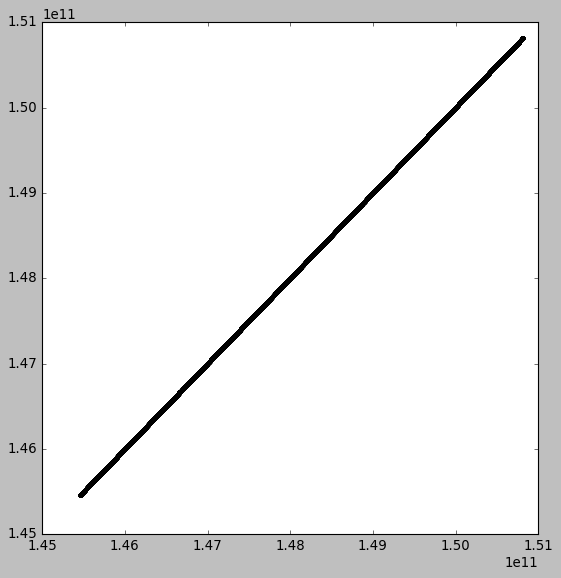

In [5]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.plot(EITmetadata['DSUN_OBS'], HIcoords.distance.value, 'k.')
plt.show()

In [6]:
EITmetadata['HI-LAT-DEG'] = HIcoords.lat.to(u.rad).value*(180./np.pi)
EITmetadata['HI-LON-DEG'] = HIcoords.lon.to(u.rad).value*(180./np.pi)


In [7]:
ascii.write(EITmetadata, "./EIT/EITresults/EIT_headerMetadata.txt", overwrite=True) 